In [1]:
from lxml import etree
import requests
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
import matplotlib.font_manager as fm
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon, shape
from shapely.prepared import prep
from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch
import mpl_toolkits.basemap.pyproj as pyproj
import fiona
from itertools import chain
from bps_utils import cmap_discretize, colorbar_index
%matplotlib inline

In [2]:
df = pd.read_csv("../data/indonesia_education-country.csv")
df.columns

Index([u'kode_provinsi', u'nama_provinsi', u'kode_kabkota', u'nama_kabkota',
       u'tingkat_pendidikan', u'jumlah_laki_laki', u'jumlah_perempuan',
       u'latitude', u'longitude'],
      dtype='object')

In [3]:
test_df = df[["nama_kabkota", "latitude", "longitude"]]

download indonesia gis shape files from [here](https://ordercitrasatelit.wordpress.com/2013/03/16/free-peta-batas-administrasi-desa-seluruh-indonesia/)

## Get shape file

In [4]:
shp = fiona.open('../data/indonesia_gis/DesaIndonesia.shp')
#shp = fiona.open('../../../Downloads/IDN_adm_shp/IDN_adm2.shp')
crs_data = shp.crs
bds = shp.bounds
shp.close()
extra = 0.01
# bounds need to be datum-shifted
wgs84 = pyproj.Proj("+init=EPSG:4326")
osgb36 = pyproj.Proj("+init=EPSG:27700")
ll = pyproj.transform(osgb36, wgs84, bds[0], bds[1])
ur = pyproj.transform(osgb36, wgs84, bds[2], bds[3])
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

## Create basemap open shape file

(66290,
 5,
 [95.010063, -11.00214, 0.0, 0.0],
 [141.007187, 5.754763, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x2c329390>)

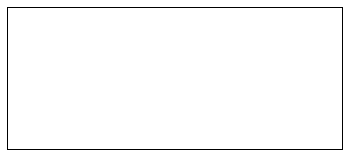

In [5]:
m = Basemap(
    projection='tmerc',
    lon_0 = 145,
    lat_0 = -10,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)
m.readshapefile(
    #'../../../Downloads/IDN_adm_shp/IDN_adm2',
    '../data/indonesia_gis/DesaIndonesia',
    'indonesia',
    color='none',
    zorder=2)

In [6]:
#m.indonesia_info

In [8]:
# select plot font
fm.findSystemFonts(fontpaths='C:\\Windows\\Fonts\\', fontext='ttf')
prop = fm.FontProperties(fname='C:\\Windows\\Fonts\\calibrii.ttf')

In [9]:
# set up a map dataframe
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.indonesia],
    'village': [w['DESA'] for w in m.indonesia_info],
    #'village': [w['NAME_2'] for w in m.indonesia_info],
})
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
df_map['village'] = df_map['village'].str.strip()

# Create Point objects in map coordinates from dataframe lon and lat values
map_points = pd.Series(
    [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(test_df['longitude'], test_df['latitude'])])
city_points = MultiPoint(list(map_points.values))
village_polygon = prep(MultiPolygon(list(df_map['poly'].values)))
# calculate points that fall within the London boundary
village_points = filter(village_polygon.contains, city_points)

In [10]:
#MultiPolygon(list(df_map['poly'].values))

In [11]:
#city_points

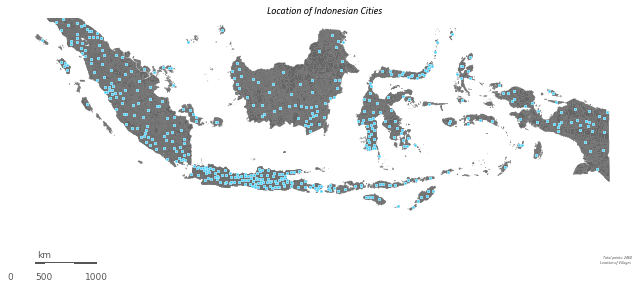

In [12]:
# draw patches from polygons
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, fc='#555555', ec='#787878', lw=.25, alpha=.9
    , zorder=4))

plt.clf()
fig = plt.figure()

ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# we don't need to pass points to m() because we calculated using map_points and shapefile polygons
dev = m.scatter(
    [geom.x for geom in village_points],
    [geom.y for geom in village_points],
    5, marker='o', lw=.25,
    facecolor='#33ccff', edgecolor='w',
    alpha=0.9, antialiased=True,
    label='Village Locations', zorder=3)
# plot cities by adding the PatchCollection to the axes instance
ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))
# copyright and source data info
smallprint = ax.text(
    1.03, 0,
    'Total points: %s\nLocation of Villages ' % len(village_points),
    ha='right', va='bottom',
    size=4,
    color='#555555',
    transform=ax.transAxes,
    fontproperties=prop,
)

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.08, coords[1] + 0.015,
    coords[0], coords[1],
    1000.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5
)
plt.title("Location of Indonesian Cities", fontproperties=prop)
plt.tight_layout()
fig.set_size_inches(8.47, 5.25)
plt.savefig('../figures/indonesian_cities.png', dpi=300, alpha=True)
plt.show()